In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# DSCI 6003 Boosting Practicum


Save all work for the below section as an ipython notebook in a single directory. 

##Introduction to Boosting Regressors

Here we will use boosting to solve a regression problem. Specifically we would
like to predict Boston house prices based on 13 features.


A) Import the following libraries.

   ```python
   from sklearn.tree import DecisionTreeRegressor
   from sklearn.ensemble import RandomForestRegressor
   from sklearn.ensemble import GradientBoostingRegressor
   from sklearn.ensemble import AdaBoostRegressor
   from sklearn.datasets import load_boston
   from sklearn.cross_validation import train_test_split, cross_val_score
   from sklearn.grid_search import GridSearchCV
   from sklearn.metrics import mean_squared_error, r2_score
   from sklearn.ensemble.partial_dependence import plot_partial_dependence
   import matplotlib.pyplot as plt
   import numpy as np
   ```

B) Import the data.

   ```python
   boston = load_boston()
   # House Prices
   y = boston.target
   # The other 13 features
   x = boston.data
   ```

   Do a `train_test_split` where `train : test` is `80 : 20`. Set
   `random_state=1` so the exact same split can be replicated later.
   All subsequent model selection will be carried out with the train set.

In [3]:
boston = load_boston()
# House Prices
y = boston.target
# The other 13 features
x = boston.data

C) We are interested in comparing 3 classes of ML algorithms here:
   - `RandomForestRegressor`
   - `AdaBoostRegressor`
   - `GradientBoostingRegressor`

   Boosted decision trees (`AdaBoost`, `GradientBoosting` & others)
   have been shown empirically to outperform `RandomForest` on average
   ([_Table 4 - R. Caruana et. al._](/readings/compare_ml_algo.pdf)) in terms
   of predictive power. The runtime for boosting algorithms, as you will
   experience, is also competitive with random forest.

   As a starting point, below are instantiations of the 3 classes of
   algorithms. I have given you a set of hyperparameters for each
   class. Do not worry about tuning the parameters for now, we will do a
   `GridSearch` at the end of the exercise.

   ```python
   rf = RandomForestRegressor(n_estimators=100,
                               n_jobs=-1,
                               random_state=1)

   gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                     loss='ls',
                                     n_estimators=100,
                                     random_state=1)

   abr = AdaBoostRegressor(DecisionTreeRegressor(),
                            learning_rate=0.1,
                            loss='linear',
                            n_estimators=100,
                            random_state=1)
   ```
   **Note:**
   `n_jobs=-1` _allows the process to be run on multiple cores on
   your computer. Only parallel algorithms such as_ `RandomForest` _can
   do that. Boosting is sequential (the current step depends on the residuals
   from the previous) and does not have that option._
   `n_jobs=-1` _is not a hyperparameter._

In [4]:
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                 loss='ls',
                                 n_estimators=100,
                                 random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(),
                        learning_rate=0.1,
                        loss='linear',
                        n_estimators=100,
                        random_state=1)

4. Using `cross_val_score` in `sklearn`, define a function that 
   calculates the cross-validated train MSE and R2 for `AdaBoostRegressor`,
   `GradientBoostingRegressor`, `RandomForestRegressor`.

   **Your output should be similar to this (Do not worry if the numbers do
   not match up exactly):**

   ```
   RandomForestRegressor Train CV | MSE: 9.881 | R2: 0.866
   GradientBoostingRegressor Train CV | MSE: 8.453 | R2: 0.886
   AdaBoostRegressor Train CV | MSE: 10.335 | R2: 0.861
   ```

   Which of the models cross validates the best? Why is it inappropriate
   to make a judgement on the performance of the models
   based only on the evidence we have thus far?

In [5]:
def get_scores(x,y,model):
    X_train, X_test, y_train, y_test = train_test_split(x,y, random_state = 1, test_size = 0.2)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    print('{0} Train CV | MSE: {1:.3f} | R2: {2:.3f}'.format(type(model).__name__,mse,r2))

get_scores(x,y,rf)
get_scores(x,y,gdbr)
get_scores(x,y,abr)

RandomForestRegressor Train CV | MSE: 8.972 | R2: 0.909
GradientBoostingRegressor Train CV | MSE: 8.395 | R2: 0.915
AdaBoostRegressor Train CV | MSE: 8.920 | R2: 0.910


5. Define a new instance of `GradientBoostingRegressor` with the exact same
   hyperparameters as above, except change the `learning_rate` to `1`
   (instead of `0.1`). Calculate the cross-validated train MSE.
    What do you notice?

In [6]:
gdbr_1 = GradientBoostingRegressor(learning_rate=1,
                                 loss='ls',
                                 n_estimators=100,
                                 random_state=1)
get_scores(x,y,gdbr_1)
# The MSE jumps up and the r2 decreases by a significant amount

GradientBoostingRegressor Train CV | MSE: 28.532 | R2: 0.711


6. We're going to make a plot to help us understand the impact of the learning rate
   and the improvements in error after each iteration of the boosting.
   
   [`staged_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.staged_predict) is a method in both
   `GradientBoostingRegressor` and `AdaBoostRegressor`. It allows us to get
   predictions from the estimator after each iteration of the boosting.
   
   Using
   `stage_predict`, define a function `stage_score_plot` that calculates the test and train
   MSE from each estimator. Do the calculations for `GradientBoostingRegressor`
   with `learning_rate=1` and `learning_rate=0.1`

   ```python
   def stage_score_plot(model, train_x, train_y, test_x, test_y):
      '''
      INPUT:
         model: GradientBoostingRegressor or AdaBoostRegressor
         train_x: 2d numpy array
         train_y: 1d numpy array
         test_x: 2d numpy array
         test_y: 1d numpy array
      
      Create a plot of the number of iterations vs the MSE for the model for
      both the training set and test set.
      '''
      
      #### YOUR CODE HERE ####
   ```
   
   You should be able to run your code like this:
   
   ```python
   stage_score_plot(gdbr, train_x, train_y, test_x, test_y)
   plt.legend()
   plt.show()
   ```
   
   And get a result which looks like this:

   ![stage_score_plot](images/stage_score_plot.png)
   
   In order to get the labels for the plot, you can use `model.__class__.__name__` to get the model name and `model.learning_rate` to get the learning rate.

In [7]:
def stage_score_plot(model, train_x, train_y, test_x, test_y):
    '''
    INPUT:
     model: GradientBoostingRegressor or AdaBoostRegressor
     train_x: 2d numpy array
     train_y: 1d numpy array
     test_x: 2d numpy array
     test_y: 1d numpy array

    Create a plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    model.fit(train_x,train_y)
    train_scores = [mean_squared_error(train_y, train_predict) for train_predict in model.staged_predict(train_x)]
    test_scores = [mean_squared_error(test_y, test_predict) for test_predict in model.staged_predict(test_x)]
    plt.plot(train_scores, label = model.__class__.__name__ + " Train - learning rate " + str(model.learning_rate), ls = '--')
    plt.plot(test_scores,label = model.__class__.__name__ + " Test - learning rate " + str(model.learning_rate))
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.title(model.__class__.__name__)

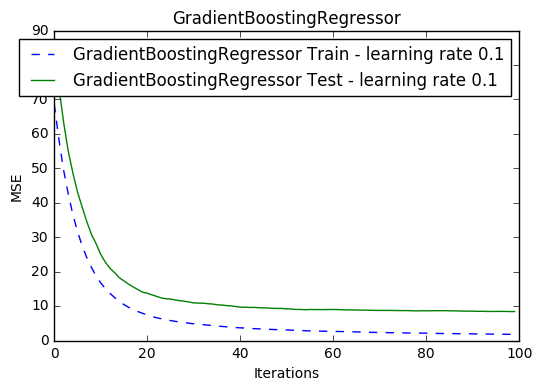

In [8]:
train_x, test_x, train_y, test_y = train_test_split(x,y, random_state = 1, test_size = 0.2)
stage_score_plot(gdbr, train_x, train_y, test_x, test_y)
plt.legend()
plt.show()     

7. Use your `stage_score_plot` function to make a plot that shows the error
   for gradient boosting with a learning rate of 0.1 and 1.

   Since you are comparing two models and we're showing both the training and
   test error, you should have 4 lines on your graph.

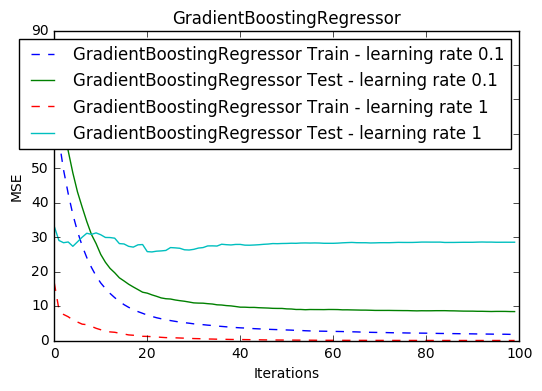

In [9]:
stage_score_plot(gdbr, train_x, train_y, test_x, test_y)
stage_score_plot(gdbr_1, train_x, train_y, test_x, test_y)
plt.legend()
plt.show()     

8. Given your plot, explain the behavior of the test / train curves
   for the two (0.1 and 1) learning rates. With a lower learning rate (0.1),
   what is necessary to obtain a low test error?

# At a learning rate of 1 the model is overfitting. In order to get a lower test rate at a low learning rate, you must do more iterations.

9. Using the `stage_score_plot` function, make a plot like you did above of
    the MSE for `GradientBoostingRegressor` with `learning_rate=0.1`.

    Add a horizontal line to indicate where the `RandomForestRegressor` test
   error is at.

   Your plot should look something like this:

   ![gradient boosting](images/gradboost.png)

   a. How many iterations does it take until Gradient Boosting beats Random Forest?

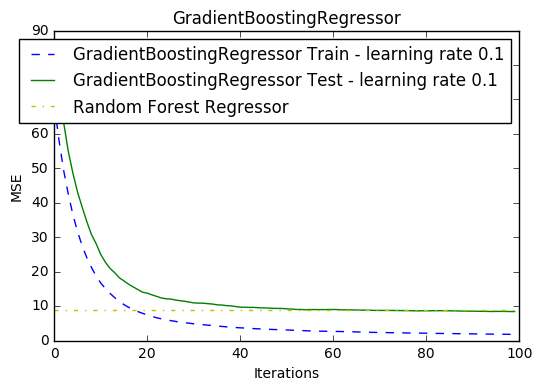

In [10]:
rf.fit(train_x, train_y)
p = rf.predict(test_x)
stage_score_plot(gdbr, train_x, train_y, test_x, test_y)
plt.axhline(mean_squared_error(test_y,p), label = 'Random Forest Regressor', ls='-.', c = 'y')
plt.legend()
plt.show()  

10. Make a similar plot for `AdaBoost`. Again have the `learning_rate=0.1`
    and add a horizontal line for the Random Forest test error.

    Don't expect AdaBoost to be as smooth as the Gradient Boosting graph.

    a. How many iterations does it take till AdaBoost beats Random Forest?

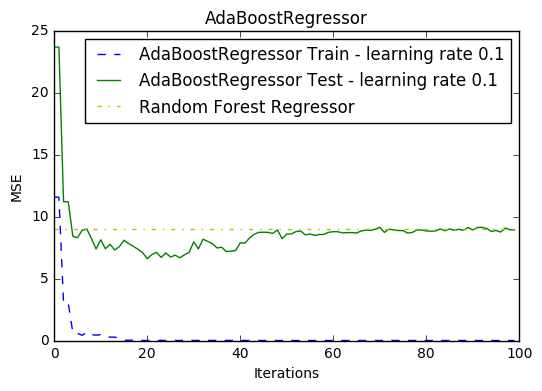

In [11]:
rf.fit(train_x, train_y)
p = rf.predict(test_x)
stage_score_plot(abr, train_x, train_y, test_x, test_y)
plt.axhline(mean_squared_error(test_y,p), label = 'Random Forest Regressor', ls='-.', c = 'y')
plt.legend()
plt.show()  

11. As seen above when we compared two learning rates, suboptimal hyperparameters
    can give rise to higher error
    (MSE). Therefore, we aim to search for the set of hyperparameters that
    would give us the lowest cross-validated train error. The search of these
    hyperparameters is known as grid-search. For each hyperparameter, a set
    of values are specified. The combination of the hyperparameters at different
    values will constitute the search space. We try each possible combination
    of parameters and find the combination which minimizes error.

    Use `GridSearchCV` for to find the best `RandomForestRegressor`
    and `GradientBoostRegressor` models respectively.
    Remember to specify `n_jobs=-1` in `GridSearchCV` to use all the cores of your
    machine and speed up your search.

    Here are some values to start out with trying for hyperparameters for Random Forest:

    ```python
    random_forest_grid = {'max_depth': [3, None],
                          'max_features': ['sqrt', 'log2', None],
                          'min_samples_split': [1, 2, 4],
                          'min_samples_leaf': [1, 2, 4],
                          'bootstrap': [True, False],
                          'n_estimators': [10, 20, 40],
                          'random_state': [1]}

    rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                                 random_forest_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='mean_squared_error')
    rf_gridsearch.fit(train_x, train_y)

    print "best parameters:", rf_gridsearch.best_params_

    best_rf_model = rf_gridsearch.best_estimator_
    ```

    Feel free to change it to try a different set of parameters.

    Note that this will take about 3-5 minutes to run. The total number of combinations is:
    `2 * 3 * 3 * 3 * 2 * 3 * 1 = 324`. We are trying each of these possibilities!

    a. What are the optimal parameters?

    b. What is the MSE you get on the test set with these parameters?

    c. How does this compare with the MSE with the default parameters?

# Notice that I did not GridSearch only once. I changed the values many times and played around until I found the optimal paramters (or atleast ones that performed better than the models out of the box). 

In [12]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [1, 2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(train_x, train_y)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    3.3s


best parameters: {'n_estimators': 40, 'max_depth': None, 'min_samples_split': 1, 'random_state': 1, 'max_features': None, 'bootstrap': True, 'min_samples_leaf': 1}


[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:   17.3s finished


In [13]:
best_rf_model.fit(train_x,train_y)
p1 = best_rf_model.predict(test_x)
mean_squared_error(test_y,p1)
#rf_best = RandomForestRegressor(**best_rf_model)

8.816969301470591

12. Go through the same process for `GradientBoosting`. Try several values for
    these hyperparameters:

    * `learning_rate`
    * `max_depth`
    * `min_samples_leaf`
    * `max_features`
    * `n_estimators`
    
    If you're unsure what values to include, take a look at sklearn's default. Include the default value and at least 
    one value less than and greater than the default value. Here's the [docs on Gradient Boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) where you can see the defaults.
    If you want a set of starting parameters, [here](https://gist.github.com/pprett/3989337#file-grid_search-py-L115) is
    a reference.

    a. What are the parameters that give the optimal model?

    b. How does the MSE for this model compare with the original MSE you got with Gradient Boosting
    before tuning the parameters?

In [47]:
gradient_boosting_grid = {'learning_rate': [0.2,0.3],
                          'max_features': [0.5,0.51],
                          'max_depth': [4,5],
                          'min_samples_leaf': [3,4],
                          'n_estimators': [130,150],
                          'random_state': [1]}

gdbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gradient_boosting_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
gdbr_gridsearch.fit(train_x, train_y)

print("best parameters:", gdbr_gridsearch.best_params_)

best_gdbr_model = gdbr_gridsearch.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
best parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.2, 'random_state': 1, 'max_features': 0.5, 'min_samples_leaf': 3}


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.7s finished


In [48]:
gdbr_gridsearch.best_params_

{'learning_rate': 0.2,
 'max_depth': 4,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'n_estimators': 150,
 'random_state': 1}

In [49]:
best_gdbr_model.fit(train_x,train_y)
p2 = best_gdbr_model.predict(test_x)
mean_squared_error(test_y,p2)

8.0360628587339615

13. Go through the same process for `AdaBoost`. Note you need to define different hyperparameters
    in the base estimator to perform the gridsearch. This will also take much longer to run,
    so feel free to just leave it running after you figure out some parameters to try.

In [85]:
adaboosting_grid = {'learning_rate': [0.1],
                    'n_estimators': [20,40,50,100],
                    'loss': ['linear'],
                    'random_state': [1]}

abr_gridsearch = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor()),
                             adaboosting_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
abr_gridsearch.fit(train_x, train_y)

print("best parameters:", abr_gridsearch.best_params_)
best_abr_model = abr_gridsearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.3s remaining:    0.4s


best parameters: {'loss': 'linear', 'n_estimators': 40, 'learning_rate': 0.1, 'random_state': 1}


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.1s finished


In [86]:
best_abr_model.fit(train_x,train_y)
p3 = best_abr_model.predict(test_x)
mean_squared_error(test_y,p3)

7.256274509803923

## Studying the AdaBoost Classifier
We have encountered `AdaBoostRegressor` and its gradient
descent variant, `GradientBoostingRegressor`. The base form of AdaBoost was
introduced in 1995 as an ensemble classifier, `AdaBoostClassifier`.
Understanding `AdaBoostClassifier` is regarded as the defacto
introduction to the world of seemingly endless variants of boosting algorithms
([refs](readings)). To gain a more entrenched understanding of boosting
in general, I would recommend [this](readings/explaining_boosting.pdf).

Make yourself familiar with the reading if you are not comfortable.

## Implementing the AdaBoost Classifier
Here we will build a simplified version of `AdaBoostClassifier`. In this case,
our classifier, `AdaBoostBinaryClassifier`, will only predict binary outcomes.
The starter code is in the [code](code) folder. The `.py` file contains the 
core functions you would have to implement this afternoon. Fill in the rest depending 
on your progress.

Your code should exactly implement this pseudocode:

![adaboost](images/adaboost_algorithm_1.png)

We're going to be using the spam dataset. It's in the [data](data) folder. You can see the feature names [here](https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names).

Here's how you should be able to run your code after you're finished:

```python
from boosting import AdaBoostBinaryClassifier
import numpy as np
from sklearn.cross_validation import train_test_split

data = np.genfromtxt('data/spam.csv', delimiter=',')

y = data[:, -1]
x = data[:, 0:-1]

train_x, test_x, train_y, test_y = train_test_split(x, y)

my_ada = AdaBoostBinaryClassifier(n_estimators=50)
my_ada.fit(train_x, train_y)
print "Accuracy:", my_ada.score(test_x, test_y)
```

1. Take a look at the `__init__` method. You shouldn't need to change anything here. Note how we are creating Decision Trees that are just stumps! (max depth is 1). 

2. Implement the `_boost` method. This will be doing steps (a)-(d) inside the for loop.

    Because we need many copies of the estimator, the first step is to clone it. This code is given for you.

    In this function `sample_weight` refers to the *wi*'s in the above description of the algorithm.

    You will need to do these steps:

    * Fix the Decision Tree using the weights. You can do this like this: `estimator.fit(x, y, sample_weight=sample_weight)`
    * Calculate the error term (`estimator_error`)
    * Calculate the alphas (`estimator_weight`)
    * Update the weights (`sample_weight`)

3. Implement the `fit` method. This is steps 1 and 2 from above.

    You should have a for loop that calls your `_boost` method `n_estimators` times. Make sure to save all the estimators in `self.estimators_`. You also need to save all the estimator weights in `self.estimator_weight_`.

4. Implement the `predict` method. This is step 3 from above.

    Note that the algorithm considers the predictions to be either -1 or 1. So once you get predictions back from your Decision Trees, change the 0's to -1's.

5. Implement the `score` method.

    This should call the predict method and then calculate the accuracy.

6. Load the file `data/spam_data.csv` into a dataframe. Use `train_test_split` to create test and train sets.
   Train your implementation of `AdaBoostBinaryClassifier` on the train set and get the train and test accuracy scores. 
   Compare your results with sklearn's [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).
   You should get approximately the same accuracy. 
   
   **Review the steps to implement the algorithm and make sure you have understood the underpinnings of boosting.**  

In [91]:
import sys
sys.path.insert(0,'./code')
from boosting import AdaBoostBinaryClassifier
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

data = np.genfromtxt('data/spam.csv', delimiter=',')

y = data[:, -1]
x = data[:, 0:-1]

train_x, test_x, train_y, test_y = train_test_split(x, y)

my_ada = AdaBoostBinaryClassifier(n_estimators=50)
my_ada.fit(train_x, train_y)
print("My Implementation Accuracy:", my_ada.score(test_x, test_y))

sklearn_ada = AdaBoostClassifier(n_estimators = 50)
sklearn_ada.fit(train_x, train_y)
print("Sklearn Accuracy:",sklearn_ada.score(test_x, test_y))

My Implementation Accuracy: 0.930495221546
Sklearn Accuracy: 0.927019982624


In [48]:
!ls

Boosting_Practicum.ipynb data                     readings
code                     images
